### OrderBook Strategies
> Betfair provides historical market-by-level exchange market data online in zipped json dumps. You have to pay to get these but usually they run schemes where you can get two months of data for free, given the large number of horse races (50+ liquid races daily) this should be plenty to train, validate and test out-of-sample some simple orderbook based trading strategies. We can perform a straightforward taking backtest to see if strategies that we create are profitable, and how much capacity they have. There are two classes included in the appropriate .py files that are used below:
1. **Race_Data**, this class takes .txt json packet data for each races, cleans it, and extracts the necesary info that we need, it then saves book snapshots into a manageable pandas csv form with a predefined snapshot interval. I typically use 100ms or 200ms, picked considering the timescale of book change, consideration of ordering latency and considerations of midprice variance vs tick size timescales.
2. **Data**, this class takes the stored pandas book frames and fits for returns on inputted features and prediction timescales. We can decide what return timescale we fit for and fold this into gridsearching strategy hyperparameters and scoring with a simple taking backtest to pick what we would  run live.


In [1]:
import json
import datetime
import dateutil.parser
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from Race_Data import Race_Data
from Data import Data
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split


%load_ext autoreload
%autoreload 2

C:\Program Files (x86)\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
instance = Data(r'C:\Users\mvopa\Desktop\Betfair\Book\book_saves', 50, ['TBI','OBI','return_5s','return_20s','return_60s','return_180s'])

>Each saved order-book snapshot has top 4 levels either side of price and quantity data, from these we construct the features: top of book imbalance (qty only of top of book), depth imbalance (qty imbalance of all 4 available levels), trailing 5,20,60 & 180seconds return for momentum/reversion. >We chose for a 50seconds returns prediction timescale. A visual representation of one races bid/offer contained in this training instance:

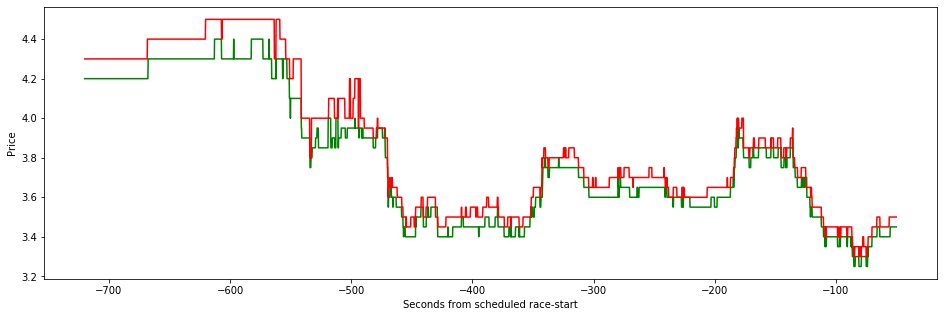

In [3]:
plt.figure(figsize=(16,5))
plt.plot(instance.frame[:3350].pt,instance.frame[:3350].BB,color='green')
plt.plot(instance.frame[:3350].pt,instance.frame[:3350].BL,color='red')
plt.xlabel('Seconds from scheduled race-start')
plt.ylabel('Price')
plt.show()

### Return prediction

We see that the R^2 is particularly low, this is expected as the data is extremely noisy. We can reduce this by cutting off $2\sigma$ outliers or so, although then we miss training for the big moves. As long as the feature weights are intuitively sensible and the test R^2 is material compared to the train R^2 then we can have some confidence that our features will be sensible directed to produce meanigful strategy configurations

In [4]:
instance.linear_fit(train_split = 0.8)

linear-fit 0.0623 R^2 train
linear-fit 0.0601 R^2 test


In [5]:
instance.xgboost_fit(train_split = 0.8)

xgboost-fit 0.089 R^2 train
xgboost-Fit 0.0787 R^2 test


> With the returns prediction we can now determine a signal indicator that will flag to buy/sell if the predicted return is above or below a set value determined by the user/strategy. This will be neatly reflected in the dataframe by the config_flag static method. Any strategy configuration can then be backtested for PnL estimation and be tested out of sample on seperate book snapshot dumps. 

### Addtions:

> Currently we have only rudimentary featuers, no trade imabalance,no momentum/reversion smoothing, no time-to-start features, no depth weighting. I think the best immediate addition to the above work is to develop the features that are being used for prediction, we should be able to explain a large amount of the order-book movements from simple & intuitive trading features given the lack of sophisticated HFT market makers in horse racing (there are only a few that I know of)